In [16]:

from statistics import mean
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize 
import json
import matplotlib.pyplot as plt
%matplotlib inline


# Objective:
Using the Food Data Central from the USDA API to pull the nutritional content of a typical Thanksgiving Meal.
I also have a twitter api data set already fetched and cleaned. I am comparing data from the Food Data Central API to data from the Twitter API. With this I can analyze the data and sucessfully ansIr some research questions.

# Research Questions:
Is there an association betIen the amount of protein and energy in a food?
Which food is the most nutritious?
Which food is the least nutritious?

In [17]:
apiKey = "yfrgdF4tHbmtDhFwkOcqitsJIiOyVkeoh8T5dadA"
params = {'api_key': apiKey}

In [18]:
response = requests.post(
       r'https://api.nal.usda.gov/fdc/v1/search',
       params=params,
       json={'generalSearchInput': "apple"}
   ) 
# saving to JSON 
item = response.json()

In [19]:
print(item)

{'totalHits': 23537, 'currentPage': 1, 'totalPages': 471, 'pageList': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'foodSearchCriteria': {'generalSearchInput': 'apple', 'pageNumber': 1, 'numberOfResultsPerPage': 50, 'pageSize': 50, 'requireAllWords': False}, 'foods': [{'fdcId': 454004, 'description': 'APPLE', 'lowercaseDescription': 'apple', 'dataType': 'Branded', 'gtinUpc': '867824000001', 'publishedDate': '2019-04-01', 'brandOwner': 'TREECRISP 2 GO', 'ingredients': 'CRISP APPLE.', 'marketCountry': 'United States', 'foodCategory': 'Pre-Packaged Fruit & Vegetables', 'modifiedDate': '2017-07-14', 'dataSource': 'LI', 'servingSizeUnit': 'g', 'servingSize': 154.0, 'householdServingFullText': '5.5 ONZ', 'tradeChannels': ['NO_TRADE_CHANNEL'], 'allHighlightFields': '<b>Ingredients</b>: CRISP <em>APPLE</em>.', 'score': 1004.9423, 'microbes': [], 'foodNutrients': [{'nutrientId': 1087, 'nutrientName': 'Calcium, Ca', 'nutrientNumber': '301', 'unitName': 'MG', 'derivationCode': 'LCCD', 'derivationDescription'

In [20]:
# creating list of foods I want to pass through to our API call
food_list=["turkey", "macaroni and cheese", "mashed potatoes", "bread stuffing", "ham",
"sIet potato souffle", "cranberry sauce", "mixed vegetables", "apple pie"
, "pecan pie"]

In [21]:
# counter that allows us to see which food word is being processed in the loop
counter = 0

# for each food,we can pull nutritional value
for food in food_list:
    counter=counter+1
    
    # sending API request
    response = requests.post(
        r'https://api.nal.usda.gov/fdc/v1/search',
        params=params,
        json={'generalSearchInput': food}
    )    
    # saving to JSON
    item = response.json()
    
    # so here I can get total matches (there can be multiple hits for one food keyword, so I need to take the length of the match object to see how many matches I got)
    l = [i for i in range(len(item['foods']))]
    for i in l:
        if i == 0:
            rdf = pd.json_normalize(item['foods'][i]['foodNutrients']) # converting json to data frame
        else: 
            df = pd.json_normalize(item['foods'][i]['foodNutrients'])
            rdf = pd.concat([rdf,df])
    
    # here I want to make the names a bit easier to read
    rdf['nutrientName'].replace('Energy','Energy',inplace=True)
    rdf['nutrientName'].replace('Carbohydrate, by difference','Carbs',inplace=True)
    rdf['nutrientName'].replace('Protein','Protein',inplace=True)
    rdf['nutrientName'].replace('Fiber, total dietary','Fiber',inplace=True)
    rdf['nutrientName'].replace('Total lipid (fat)','Fat',inplace=True)
    rdf['nutrientName'].replace('Sodium, Na','Sodium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total saturated','Sat_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Calcium, Ca','Calcium',inplace=True)
    rdf['nutrientName'].replace('Iron, Fe','Iron',inplace=True)
    rdf['nutrientName'].replace('Sugars, total including NLEA','Sugar',inplace=True)
    rdf['nutrientName'].replace('Cholesterol','Chol',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total trans','Trans_Fatty_Acids',inplace=True)
    rdf['nutrientName'].replace('Vitamin C, total ascorbic acid','VitaminC',inplace=True)
    rdf['nutrientName'].replace('Vitamin A, IU','VitaminA',inplace=True)
    rdf['nutrientName'].replace('Potassium, K','Potassium',inplace=True)
    rdf['nutrientName'].replace('Fatty acids, total polyunsaturated','Unsat_Fatty_Acids',inplace=True)   
  
    # finding average nutrient per row
    agg_food = rdf[['nutrientName','value']].groupby(['nutrientName']).agg('mean')
    agg_food = agg_food.reset_index()
    agg_food.columns = ["nutrientName","Value"]    
    # subseting data to only include the nutrients I want
    agg_food = agg_food[agg_food["nutrientName"].isin(['Energy','Carbs','Protein','Fiber','Fat'])]
    agg_food["Food"] = food 
    # transposing the data so the nutrient values are their own columns
    new=agg_food.pivot_table(index=["Food"], columns=['nutrientName'], values='Value')
    new.reset_index(inplace=True)
    # appending the food match to a dataframe with all foods
    if counter ==1: 
        all_foods=new
    else:
        all_foods=pd.concat([all_foods,new]) 

In [24]:
all_foods

nutrientName,Food,Carbs,Energy,Fat,Fiber,Protein
0,turkey,7.726800,393.138462,11.490800,0.457447,16.309400
0,macaroni and cheese,21.293000,337.333333,7.169800,1.040000,6.768000
0,mashed potatoes,42.385417,240.960784,4.355000,3.264583,4.762083
0,bread stuffing,27.434200,361.586207,9.924400,2.394000,8.527600
0,ham,8.709600,286.032787,8.660400,0.602381,13.732400
0,sweet potato souffle,25.576531,232.327869,6.303878,2.536735,3.087143
0,cranberry sauce,26.694375,219.115942,0.948571,1.880851,1.860200
0,mixed vegetables,9.873750,49.780000,0.046250,2.220408,1.726122
0,apple pie,37.482979,337.173077,12.863830,2.243478,2.860851
0,pecan pie,42.379600,500.481481,24.097600,2.757143,4.743000


# Research question:
Is there an association betIen the amount of protein and energy in a food?

Pearson value:  0.4292342361793382


Text(0.5, 1.0, 'Protein Vs Energy in food')

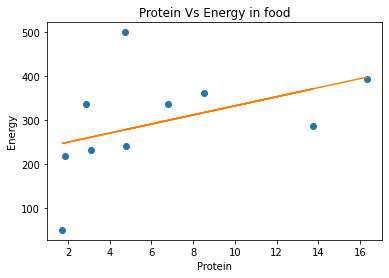

In [36]:
#scatter plot of the protein and energy in all foods
all_foods.plot.scatter(x='Protein',y='Energy')
x=all_foods['Protein']
y=all_foods['Energy']
m, b = np.polyfit(x, y, 1)
plt.plot(x, y, 'o')
plt.plot(x, m*x + b)
from scipy.stats import pearsonr
corr, p = pearsonr(x, y)
print('Pearson value: ', corr)
plt.xlabel("Protein")
plt.ylabel("Energy")
plt.title("Protein Vs Energy in food")

In this graph, I can see the comparison between the protein and energy in food. I can see a very slight correlation between the protein and energy in the food. starting off I see that as the protein leaves the second concentration or value, the values go up. Not steadily due to one outlier which is the outlier where the protein is 5 and the energy is at 500 but I can see that other than that, the points seem to be close to touching the line which hints a clear correlation but they dont touch the line which indicates a slight but very visible relationship and correlation. Another way we can see this is from the correlation value. Estimated to be at .43 is a weak positive correlation.

# Research Inquiry:
Looking at relationships betIen the nutrient concentration across all the food items.

Text(0.5, 1.0, 'Foods Vs Carbs in food')

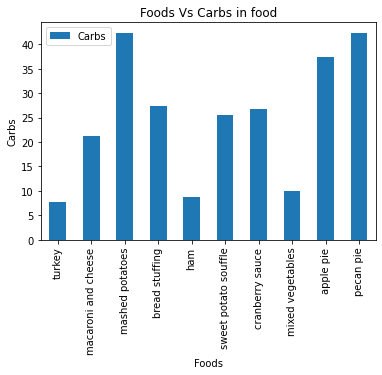

In [38]:
all_foods.plot.bar(x='Food',y='Carbs')
plt.xlabel("Foods")
plt.ylabel("Carbs")
plt.title("Foods Vs Carbs in food")

Here I have the nutrient concentration for the foods and the amount of carbs it has. Basically, I can see that pecan pie has the most concentration of carbs in it. I can guess that because it is made of bread and filling. I see apple pie coming as a close second because of the same reason for pecan pie. I see mashed potatoes because of the amount of starch so it has carbs but I also see that the least amount of carbs are meats and veggies like turkey, ham and mixed veggies which is understandable.

Text(0.5, 1.0, 'Foods Vs Energy in food')

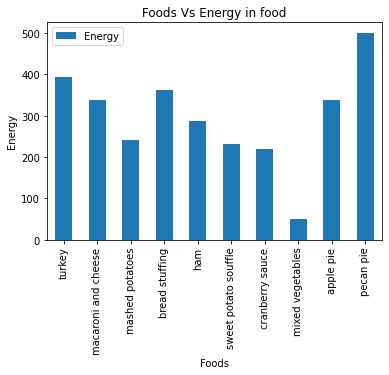

In [43]:
all_foods.plot.bar(x='Food',y='Energy')
plt.xlabel("Foods")
plt.ylabel("Energy")
plt.title("Foods Vs Energy in food")

Here I see a comparison betIen the amount of energy there is in each type of food. Here I can see that similar to the carbs, pecan pie holds the most concentration of energy in the food. this can be due to the fact that pecan pie is made with alot of sugar which gives energy to most people. Surpringly, I see turkey coming as second for most amount of energy. I find it surprising because turkey has tryptophan which makes people drowsy and sleepy. Lastly, I see mixed veggies as the least amount of energy. It seems as if veggies do not have energy but everything else gives us energy. 

Text(0.5, 1.0, 'Foods Vs Fat in food')

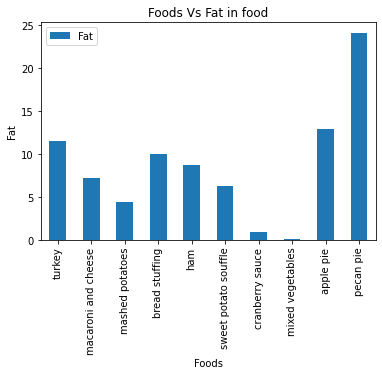

In [44]:
all_foods.plot.bar(x='Food',y='Fat')
plt.xlabel("Foods")
plt.ylabel("Fat")
plt.title("Foods Vs Fat in food")

Here I are seeing the amount of fat in each food. Once again, pecan pie has the highest concentration of fat. After that, I see apple pie coming in as second then turkey. These results are similar to the graphs regarding carbs and energy. It helps us conclude that when a food has alot of sugar in it, it might have fat in it as well which gives you some types of energy because of the carbs in it. 

Text(0.5, 1.0, 'Foods Vs Fiber in food')

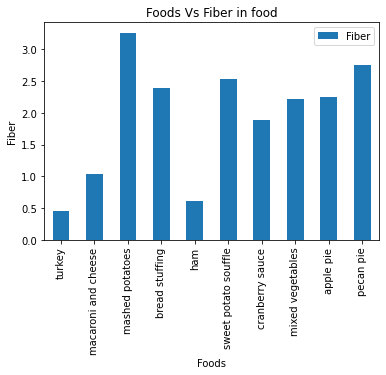

In [45]:
all_foods.plot.bar(x='Food',y='Fiber')
plt.xlabel("Foods")
plt.ylabel("Fiber")
plt.title("Foods Vs Fiber in food")

Here I are seeing comparisons of fiber in food.Mashed potatoes have the most fiber then I have pecan pie and sweet potato souffle coming in after the mashed potatoes. Next I see the ones with less fiber are the meats. Ham has the second to least amount of fiber and turkey has the least amount of fiber. This can be due to the fact that they dont come from plants which are high in fiber.

Text(0.5, 1.0, 'Foods Vs Protein in food')

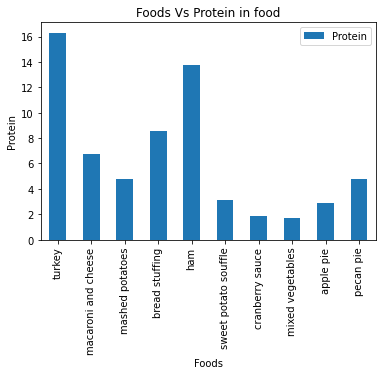

In [46]:
all_foods.plot.bar(x='Food',y='Protein')
plt.xlabel("Foods")
plt.ylabel("Protein")
plt.title("Foods Vs Protein in food")

Here I see the comparison in foods and their concentration in protein content. I see that turkey has the most amount of protein. I then see ham as having the second most amount and bread stuffing at the third most amount. The meats have alot of protein because of the fact that meat generally has alot of amina acids which I learned are biologically the building blocks of protein. I see that the cranberry sauce and veggies have the least amount of protein probably because they are they are more plant and fruit based which are generally low in amino acids. 

# Interpretations and comments

In the previous cells, we had the oppotunity of seeing correlations between nurient values and all the foods. This gave us a view of the common thanksgiving foods and what impacts they have on us and our family members

I think out of all of the foods, turkey is the healthies meal. it is the highest in protein and I think having alot of protein is healthy. I believe that having too much of something is not good but eating a good and healthy amount of protein helps you retain your muscles and helps you have stronger bones. Additionally, statisically speaking, it provides alot of energy too. Having alot of energy is very healthy because it allows you to move around more and maybe gets you to be more motivated to do more things during the day. This energy can give you motivation to go to the gym which is always a good thing so i think turkey is the healthiest option.

I think pecan pie is the least healthy. Yes it does have alot of energy and fiber which is essential to having a healthy lifestyle but it is also packed with sugar. Humans get addicted to sugar sometimes and so when you have too many slices of pie, then it becomes a problem. Even though pecan pie has alot of benefits, people do tend to go overboard sometimes and its easier to get unhealthy from large amounts of sugar. It is implied to only have a small amount occationally because it is also high in fat and carbs which can make you gain weight and make you very unhealthy. 

In [54]:
#importing the foods tweets api dataset already transformed
#This dataset consists of a list of tweets that mentioned some of the many Thanksgiving food words on Thanksgiving Day.
#These tweets were collected using the Twitter Streaming API, which allows users to collect public tweets in real-time.
foodtweets = pd.read_csv('food_tweets_mentions.csv')

In [55]:
foodtweets.head()

,tweet_id,food_mention,num_retweets,num_favorites
0,1,turkey,955,621
1,2,turkey,318,124
2,3,turkey,357,787
3,4,turkey,615,328
4,5,turkey,764,672


In [57]:
foodtweets['num_retweets'].mean()

496.8153526970954

In [58]:
foodtweets['num_favorites'].mean()

499.7240663900415

In [59]:
foodtweets['num_retweets'].max()

1000

In [60]:
foodtweets['num_favorites'].max()

999

Here I have descriptive statistics based on a dataframe that stems from a twitter api that has list of tweets with thanksgiving key words mentioned. When doing the descriptive stats, I Calculated the average number of retweets per tweet which came out to be  around 496.8153. I then 
Calculated the average number of favorites per tweet which came to be around 499.72406. I also Calculated the maximum number of retweets for a single tweet which was 1000. Lastly, I Calculated the maximum number of favorites for a single tweet which was 999. 

Text(0.5, 1.0, 'Distribution of the number of retweets')

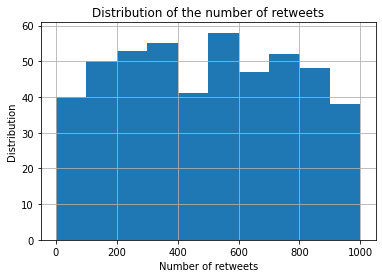

In [61]:
foodtweets["num_retweets"].hist()
plt.xlabel("Number of retweets")
plt.ylabel("Distribution")
plt.title("Distribution of the number of retweets")

Here I see a distribution for the number of tweets in the sample. I would say this is more of a non uniform distribution because of the dip in the middle but I also see a dip at the begining, end and in the 600 range as well.

Text(0.5, 1.0, 'Distribution of the number of favorited tweets')

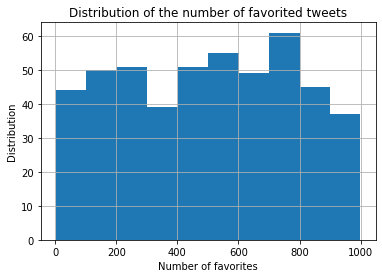

In [62]:
foodtweets["num_favorites"].hist()
plt.xlabel("Number of favorites")
plt.ylabel("Distribution")
plt.title("Distribution of the number of favorited tweets")

Here I see a distribution for the number of tweets in the sample that are favorited. I would say this is more of a non uniform distribution because of the dip near the middle but I also see a dip at the end and in the 600 range as well.

In [68]:
#Here the goal is to subset the tweets dataset to those tweets where the number of retweets is 
#greater than 200 AND the number of favorites is greater than 50. there is a much easier way to do this but 
#I chose to do this because I like to look at my data for each condition.
first=foodtweets.loc[foodtweets['tweet_id']>200] 
first

,tweet_id,food_mention,num_retweets,num_favorites
200,201,sweet potato souffle,218,422
201,202,sweet potato souffle,406,149
202,203,sweet potato souffle,826,691
203,204,sweet potato souffle,725,53
204,205,sweet potato souffle,786,798
...,...,...,...,...
477,478,pumpkin pie,837,303
478,479,pumpkin pie,130,514
479,480,pumpkin pie,450,847
480,481,pumpkin pie,260,292


In [69]:
second=foodtweets.loc[foodtweets['num_favorites']>50]
second

,tweet_id,food_mention,num_retweets,num_favorites
0,1,turkey,955,621
1,2,turkey,318,124
2,3,turkey,357,787
3,4,turkey,615,328
4,5,turkey,764,672
...,...,...,...,...
477,478,pumpkin pie,837,303
478,479,pumpkin pie,130,514
479,480,pumpkin pie,450,847
480,481,pumpkin pie,260,292


In [71]:
#now we just have to concatinate the two frames
frames = [second, first]
food_tweets_subset = pd.concat(frames)
display(food_tweets_subset)

,tweet_id,food_mention,num_retweets,num_favorites
0,1,turkey,955,621
1,2,turkey,318,124
2,3,turkey,357,787
3,4,turkey,615,328
4,5,turkey,764,672
...,...,...,...,...
477,478,pumpkin pie,837,303
478,479,pumpkin pie,130,514
479,480,pumpkin pie,450,847
480,481,pumpkin pie,260,292


In [74]:
#the goal for the following is to use the subsetted dataset (food_tweets_subset) and create an aggregated dataframe with the 
#number of tweets for each food item mentioned, the total number of retweets for each food item mentioned and the average number 
#of favorites for each food item mentioned. After that we can put that frame with the original all_foods frame.

In [75]:
ndf = food_tweets_subset[['num_retweets','food_mention']].groupby(['food_mention']).agg('sum')
ndf

,num_retweets
food_mention,
apple pie,8111
bean casserole,17075
bread stuffing,10736
cranberry sauce,4829
dinner rolls,9112
gravy,8725
ham,27759
macaroni and cheese,45689
mashed potatoes,2820


In [76]:
ndf = ndf.reset_index()
ndf.columns = ["food_mention","total_num_retweet"]
ndf

,food_mention,total_num_retweet
0,apple pie,8111
1,bean casserole,17075
2,bread stuffing,10736
3,cranberry sauce,4829
4,dinner rolls,9112
5,gravy,8725
6,ham,27759
7,macaroni and cheese,45689
8,mashed potatoes,2820
9,mixed vegetables,145837


In [77]:
nndf = food_tweets_subset[['tweet_id','food_mention']].groupby(['food_mention']).agg('count')
nndf

,tweet_id
food_mention,
apple pie,21
bean casserole,36
bread stuffing,23
cranberry sauce,13
dinner rolls,16
gravy,23
ham,61
macaroni and cheese,89
mashed potatoes,6


In [78]:
nndf = nndf.reset_index()
nndf.columns = ["food_mention","num_tweets"]
nndf

,food_mention,num_tweets
0,apple pie,21
1,bean casserole,36
2,bread stuffing,23
3,cranberry sauce,13
4,dinner rolls,16
5,gravy,23
6,ham,61
7,macaroni and cheese,89
8,mashed potatoes,6
9,mixed vegetables,289


In [79]:
nedf = food_tweets_subset[['num_favorites','food_mention']].groupby(['food_mention']).agg('mean')
nedf

,num_favorites
food_mention,
apple pie,346.142857
bean casserole,489.388889
bread stuffing,554.391304
cranberry sauce,416.615385
dinner rolls,688.000000
gravy,397.739130
ham,551.295082
macaroni and cheese,558.876404
mashed potatoes,468.833333


In [80]:
nedf = nedf.reset_index()
nedf.columns = ["food_mention","avg_num_favorites"]
nedf

,food_mention,avg_num_favorites
0,apple pie,346.142857
1,bean casserole,489.388889
2,bread stuffing,554.391304
3,cranberry sauce,416.615385
4,dinner rolls,688.000000
5,gravy,397.739130
6,ham,551.295082
7,macaroni and cheese,558.876404
8,mashed potatoes,468.833333
9,mixed vegetables,511.851211


In [81]:
food_tweets_subset_aggs = pd.merge(nndf,ndf,on=['food_mention'])
food_tweets_subset_aggs

,food_mention,num_tweets,total_num_retweet
0,apple pie,21,8111
1,bean casserole,36,17075
2,bread stuffing,23,10736
3,cranberry sauce,13,4829
4,dinner rolls,16,9112
5,gravy,23,8725
6,ham,61,27759
7,macaroni and cheese,89,45689
8,mashed potatoes,6,2820
9,mixed vegetables,289,145837


In [82]:
food_tweets_subset_agg = pd.merge(food_tweets_subset_aggs,nedf,on=['food_mention'])
food_tweets_subset_agg

,food_mention,num_tweets,total_num_retweet,avg_num_favorites
0,apple pie,21,8111,346.142857
1,bean casserole,36,17075,489.388889
2,bread stuffing,23,10736,554.391304
3,cranberry sauce,13,4829,416.615385
4,dinner rolls,16,9112,688.000000
5,gravy,23,8725,397.739130
6,ham,61,27759,551.295082
7,macaroni and cheese,89,45689,558.876404
8,mashed potatoes,6,2820,468.833333
9,mixed vegetables,289,145837,511.851211


In [83]:
repm=food_tweets_subset_agg.rename(columns = {'food_mention':'Food'}, inplace = True)

In [84]:
food_tweets_subset_agg

,Food,num_tweets,total_num_retweet,avg_num_favorites
0,apple pie,21,8111,346.142857
1,bean casserole,36,17075,489.388889
2,bread stuffing,23,10736,554.391304
3,cranberry sauce,13,4829,416.615385
4,dinner rolls,16,9112,688.000000
5,gravy,23,8725,397.739130
6,ham,61,27759,551.295082
7,macaroni and cheese,89,45689,558.876404
8,mashed potatoes,6,2820,468.833333
9,mixed vegetables,289,145837,511.851211


In [85]:
everything=pd.merge(all_foods,food_tweets_subset_agg, how='inner',on=['Food'])

In [86]:
everything

,Food,Carbs,Energy,Fat,Fiber,Protein,num_tweets,total_num_retweet,avg_num_favorites
0,turkey,7.726800,393.138462,11.490800,0.457447,16.309400,27,14463,495.481481
1,macaroni and cheese,21.293000,337.333333,7.169800,1.040000,6.768000,89,45689,558.876404
2,mashed potatoes,42.385417,240.960784,4.355000,3.264583,4.762083,6,2820,468.833333
3,bread stuffing,27.434200,361.586207,9.924400,2.394000,8.527600,23,10736,554.391304
4,ham,8.709600,286.032787,8.660400,0.602381,13.732400,61,27759,551.295082
5,sweet potato souffle,25.576531,232.327869,6.303878,2.536735,3.087143,30,18760,408.333333
6,cranberry sauce,26.694375,219.115942,0.948571,1.880851,1.860200,13,4829,416.615385
7,mixed vegetables,9.873750,49.780000,0.046250,2.220408,1.726122,289,145837,511.851211
8,apple pie,37.482979,337.173077,12.863830,2.243478,2.860851,21,8111,346.142857
9,pecan pie,42.379600,500.481481,24.097600,2.757143,4.743000,22,11078,627.000000


# Question:
Is there a linear relationship between the amount of carbs in a food item (according to the FoodData Central API) and the average number of favorites on Twitter?

-0.14576471647270137


Text(0.5, 1.0, 'Carbs and Average tweet Favorites Relationship')

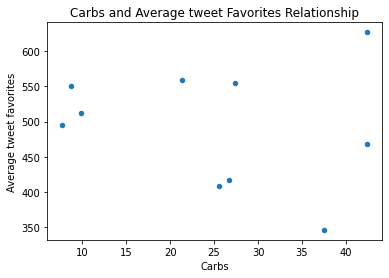

In [89]:
everything.plot.scatter(x='Carbs',y='avg_num_favorites')
x=everything['Carbs']
y=everything['avg_num_favorites']
from scipy.stats import pearsonr
corr, p = pearsonr(x, y)
print(corr)
plt.xlabel("Carbs")
plt.ylabel("Average tweet favorites")
plt.title("Carbs and Average tweet Favorites Relationship")

Here I can see the relationship betIen the number of carbs and the average tweet favorite. I can see that there is a weak negative linear relationship between the variables. I say this because yes, there is an outlier all the way at the top but I see the trend going down sort of as the carb numnbers increase I see the average tweet favorites decrease. It is not exact but I can notice it. we can see that this correlation is infact weak because when calculating the pearson correaltion, it did in fact give me a negative which shows a weak negative relationship